<a href="https://colab.research.google.com/github/ShohTagawa/LLMs-from-scratch/blob/main/hiragana_gpt_fixed_(6_3M).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 ひらがなGPT - AIに日本語を教えよう！

## 📖 このノートブックで学ぶこと

このノートブックでは、**ChatGPTと同じ仕組み（Transformer）** を使って、
日本語の文章を生成するAIを一から作ります。

### 🎯 到達目標
1. **AIがどうやって文章を理解するか**を知る
2. **Transformerの仕組み**を理解する
3. **実際に動くAI**を自分で作る
4. **学習の様子**をグラフで確認する

### ✨ 改善版の特徴
この改善版では、AIをより賢くするための**3つの新技術**を追加しています：
1. **Learning Rate Scheduler** - 学習速度を自動調整
2. **Gradient Clipping** - 学習の安定化
3. **Weight Decay** - 過学習の防止

### 💡 予備知識
- **必要**: なし！（初めてでOK）
- **あると便利**: Pythonの基本（変数、リスト、関数）

---

## 🗺️ 全体の流れ

```
1. 準備 → 2. データを見る → 3. AIを作る → 4. 学習 → 5. 文章生成！
```

それでは始めましょう！ 🚀

---

# 📦 ステップ1: 準備（ライブラリの読み込み）

## 🤔 ライブラリって何？

プログラムを書くときに便利な「道具箱」のようなものです。

- **PyTorch**: AIを作るための道具
- **matplotlib**: グラフを描く道具
- **numpy**: 数値計算の道具

下のセルを実行してください！ ▶️ボタンを押すか、`Shift + Enter`

In [1]:
# 必要なライブラリを読み込む
import torch              # AI（ニューラルネットワーク）を作るための基本ツール
import torch.nn as nn     # ニューラルネットワークの部品
from torch.nn import functional as F  # よく使う関数たち
import os                 # ファイル操作
from datetime import datetime  # 時刻の表示
import matplotlib.pyplot as plt  # グラフを描く
import numpy as np        # 数値計算

torch.serialization.add_safe_globals([np.core.multiarray.scalar])

# 日本語フォント設定（グラフで日本語を表示するため）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# 実行環境の確認
print("="*70)
print("🎉 ライブラリの読み込み成功！")
print("="*70)
print(f"📅 実行開始時刻: {datetime.now().strftime('%Y年%m月%d日 %H:%M:%S')}")
print(f"🔧 PyTorchバージョン: {torch.__version__}")
print(f"💻 GPU（高速計算）は使える？ {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   → 使えます！ GPU名: {torch.cuda.get_device_name(0)}")
    print(f"   → 学習が速くなります ⚡")
else:
    print(f"   → CPUで動きます（GPUより遅いですが問題なし）")

print("="*70)
print("✅ 準備完了！次のステップへ進みましょう")
print("="*70)

🎉 ライブラリの読み込み成功！
📅 実行開始時刻: 2025年10月07日 03:16:15
🔧 PyTorchバージョン: 2.8.0+cu126
💻 GPU（高速計算）は使える？ True
   → 使えます！ GPU名: Tesla T4
   → 学習が速くなります ⚡
✅ 準備完了！次のステップへ進みましょう


/tmp/ipython-input-565329490.py:10: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([np.core.multiarray.scalar])


---

# ⚙️ ステップ2: 設定（ハイパーパラメータ）

## 🎛️ ハイパーパラメータって何？

AIの性能を決める「調整ダイヤル」のようなものです。

### 📊 主な設定項目

| 項目 | 意味 | 例え |
|------|------|------|
| `n_embd` | AIの頭の良さ | 脳のサイズ 🧠 |
| `n_layer` | 思考の深さ | 考える回数 🤔 |
| `n_head` | 視点の数 | 目の数 👀 |
| `learning_rate` | 学習の速さ | 歩幅の大きさ 👣 |

---

### 1. Learning Rate Scheduler（学習率スケジューラ）
**学習速度を自動調整する仕組みです**

- **ウォームアップ期間**: 最初はゆっくり学習（慎重に）
- **コサイン減衰**: 徐々に学習速度を下げる（繊細に）
- **効果**: 学習が安定し、Lossが下がりやすくなる

例えると...
- 車の運転: 最初はゆっくり発進 → だんだん加速 → 目的地に近づいたら減速

### 2. Gradient Clipping（勾配クリッピング）
**学習の「暴走」を防ぐ仕組みです**

- AIが学習する時、時々計算が爆発的に大きくなることがあります
- これを防ぐため、一定以上大きくならないように制限します
- **効果**: 学習が安定し、途中で壊れにくくなる

例えると...
- 車のスピードリミッター: どんなにアクセルを踏んでも一定速度以上出ない

### 3. Weight Decay（重み減衰 / L2正則化）
**AIの「暗記」を防ぐ仕組みです**

- AIは時々、答えを暗記してしまうことがあります（過学習）
- これを防ぐため、パラメータが大きくなりすぎないようにします
- **効果**: 見たことないデータでも正しく動くようになる

例えると...
- 試験勉強: 答えを丸暗記するのではなく、理解して覚える

---

## 💡 実験してみよう！

下の値を変えて実験できます。
まずは**そのまま実行**して、後で変えてみましょう。

In [3]:
# ==============================================================================
# 🎛️ ここを変更して実験できます！
# ==============================================================================

# --- データ処理の設定 ---
batch_size = 64       # 一度に何個の文章を学習する？（大→速いが重い、小→遅いが軽い）
block_size = 128      # 何文字分を一度に見る？（大→長い文脈、小→短い文脈）

# --- 学習の設定 ---
max_iters = 12000      # 何回繰り返し学習する？
eval_interval = 100   # 何回ごとに成績をチェックする？
learning_rate = 3e-4  # 学習速度の初期値
eval_iters = 100      # 成績チェックの精度

# --- AIの構造（改善版: より強力に）---
n_embd = 256         # 脳のサイズ（改善版: 256→384に増加）
n_head = 8            # 何個の視点で見る？（改善版: 8→6に調整）
n_layer = 8           # 何層の思考？（改善版: 6→8層に増加）
dropout = 0.1         # 過学習防止（改善版: 0.2→0.1に減少）

# --- 🆕 改善版で追加された設定 ---

# Learning Rate Scheduler設定
warmup_iters = 100          # ウォームアップ期間（最初100回はゆっくり学習）
lr_decay_iters = max_iters  # 減衰期間（全体で徐々に減速）
min_lr = 6e-5               # 最小学習率（初期の1/10まで下げる）

# Gradient Clipping設定
grad_clip = 1.0       # 勾配の最大値（これ以上大きくならない）

# Weight Decay設定
weight_decay = 1e-1   # L2正則化の強さ（0.1 = やや強め）

# --- チェックポイント（途中経過の保存）---
checkpoint_intervals = [1, 50, 100, 200, 400, 750]  # 最初は細かく保存
checkpoint_interval_regular = 250  # 750回以降は250回ごと
checkpoint_dir = 'checkpoints'     # 保存先フォルダ

# --- 自動停止の設定 ---
patience = 20         # 何回改善しなかったら諦める？（改善版: 8→15に増加）
min_delta = 0.001     # どれくらい改善したら「改善」とみなす？

# ==============================================================================

# 計算デバイスの決定（GPUがあればGPU、なければCPU）
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 設定の表示
print("\n" + "="*70)
print("⚙️  ハイパーパラメータ設定（改善版）")
print("="*70)

print(f"\n🖥️  【実行環境】")
print(f"   計算デバイス: {device}")
if device == 'cuda':
    print(f"   💨 GPUで高速実行します！")
else:
    print(f"   🐢 CPUで実行します（GPUより遅いですが動きます）")

print(f"\n📦 【データ処理】")
print(f"   バッチサイズ: {batch_size} 個")
print(f"   コンテキスト長: {block_size} 文字")
print(f"   → 一度に{batch_size}個の{block_size}文字の文章を学習")

print(f"\n🧠 【AIの構造】（改善版）")
print(f"   埋め込み次元: {n_embd} （256→384に強化）")
print(f"   Attention Head: {n_head} 個")
print(f"   Transformer層: {n_layer} 層 （6→8層に強化）")
print(f"   Dropout率: {dropout}")
print(f"   → 予想パラメータ数: 約{(n_embd * n_embd * n_layer * 12) / 1e6:.1f}M個")

print(f"\n📚 【学習設定】")
print(f"   初期学習率: {learning_rate} （3e-4→6e-4に上昇）")
print(f"   最大イテレーション: {max_iters:,} 回 （3000→5000に増加）")
print(f"   評価間隔: {eval_interval} 回ごと")

print(f"\n🆕 【改善版の新機能】")
print(f"   1️⃣ Learning Rate Scheduler:")
print(f"      - ウォームアップ: {warmup_iters}回")
print(f"      - 最小学習率: {min_lr}")
print(f"      → 最初はゆっくり、徐々に速く、最後は丁寧に学習")
print(f"\n   2️⃣ Gradient Clipping:")
print(f"      - 勾配の上限: {grad_clip}")
print(f"      → 学習の暴走を防止")
print(f"\n   3️⃣ Weight Decay:")
print(f"      - 正則化強度: {weight_decay}")
print(f"      → 過学習（暗記）を防止")

print(f"\n💾 【チェックポイント】")
print(f"   初期保存タイミング: {checkpoint_intervals}")
print(f"   以降の保存間隔: {checkpoint_interval_regular} 回ごと")

print(f"\n⏹️  【Early Stopping】")
print(f"   忍耐力: {patience} 回 （8→15に増加）")
print(f"   改善判定: {min_delta}")

print("\n" + "="*70)
print("✅ 設定完了！次はデータを見てみましょう")
print("="*70)

# フォルダ作成
os.makedirs(checkpoint_dir, exist_ok=True)


⚙️  ハイパーパラメータ設定（改善版）

🖥️  【実行環境】
   計算デバイス: cuda
   💨 GPUで高速実行します！

📦 【データ処理】
   バッチサイズ: 64 個
   コンテキスト長: 128 文字
   → 一度に64個の128文字の文章を学習

🧠 【AIの構造】（改善版）
   埋め込み次元: 256 （256→384に強化）
   Attention Head: 8 個
   Transformer層: 8 層 （6→8層に強化）
   Dropout率: 0.1
   → 予想パラメータ数: 約6.3M個

📚 【学習設定】
   初期学習率: 0.0003 （3e-4→6e-4に上昇）
   最大イテレーション: 12,000 回 （3000→5000に増加）
   評価間隔: 100 回ごと

🆕 【改善版の新機能】
   1️⃣ Learning Rate Scheduler:
      - ウォームアップ: 100回
      - 最小学習率: 6e-05
      → 最初はゆっくり、徐々に速く、最後は丁寧に学習

   2️⃣ Gradient Clipping:
      - 勾配の上限: 1.0
      → 学習の暴走を防止

   3️⃣ Weight Decay:
      - 正則化強度: 0.1
      → 過学習（暗記）を防止

💾 【チェックポイント】
   初期保存タイミング: [1, 50, 100, 200, 400, 750]
   以降の保存間隔: 250 回ごと

⏹️  【Early Stopping】
   忍耐力: 20 回 （8→15に増加）
   改善判定: 0.001

✅ 設定完了！次はデータを見てみましょう


---

# 📚 ステップ3: データの読み込み

## 📖 AIに何を教える？

AIは**たくさんの文章を読んで**日本語を学びます。
今回は夏目漱石の「こころ」をひらがなにしたものを使います。

### 📋 準備
1. 左のフォルダアイコン 📁 をクリック
2. `input.txt` をアップロード
3. このセルを実行

※ ファイルがない場合はサンプルデータで動きます

In [5]:
print("\n" + "="*70)
print("📖 データ読み込み中...")
print("="*70)

# ファイルの読み込み
if os.path.exists('input.txt'):
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    print("✅ input.txt を読み込みました！")
else:
    print("⚠️  input.txt が見つかりません")
    print("   サンプルデータで動かします")
    print("   本格的な学習には input.txt をアップロードしてください\n")
    text = """わたくしは そのひとを つねに せんせいと よんでいた。 だから ここでも ただ せんせいと かくだけで ほんみょうは うちあけない。 これは せけんを はばかる えんりょという よりも、 そのほうが わたくしに とって しぜんだから である。
わたくしは そのひとの きおくを よびおこす ごとに、 すぐ せんせいと いいたく なる。 ふでを とっても こころもちは おなじ ことで ある。 よそよそしい かしらもじなどは とても つかう きに ならない。""" * 20

# 基本的な統計
print(f"\n📊 データの基本情報")
print("-"*70)
print(f"総文字数: {len(text):,} 文字")
print(f"バイト数: {len(text.encode('utf-8')):,} bytes")

# どんな文字が使われているか
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"\n🔤 使われている文字の種類: {vocab_size} 種類")
print("   ↓ これがAIの「語彙」になります\n")

# すべての文字を10個ずつ表示
print("【すべての文字（トークン）一覧】")
print("-"*70)
for i in range(0, len(chars), 10):
    chunk = chars[i:i+10]
    display = ' '.join([f"{char}({i+j})" for j, char in enumerate(chunk)])
    print(f"{i:3d}-{min(i+9, len(chars)-1):3d}: {display}")
print("-"*70)

print("\n" + "="*70)
print("✅ データ読み込み完了！")
print("="*70)


📖 データ読み込み中...
✅ input.txt を読み込みました！

📊 データの基本情報
----------------------------------------------------------------------
総文字数: 1,790,079 文字
バイト数: 4,682,269 bytes

🔤 使われている文字の種類: 70 種類
   ↓ これがAIの「語彙」になります

【すべての文字（トークン）一覧】
----------------------------------------------------------------------
  0-  9: 
(0)  (1) K(2) 、(3) 。(4) 「(5) 」(6) ぁ(7) あ(8) ぃ(9)
 10- 19: い(10) ぅ(11) う(12) ぇ(13) え(14) ぉ(15) お(16) か(17) き(18) く(19)
 20- 29: け(20) こ(21) さ(22) し(23) す(24) せ(25) そ(26) た(27) ち(28) っ(29)
 30- 39: つ(30) て(31) と(32) な(33) に(34) ぬ(35) ね(36) の(37) は(38) ひ(39)
 40- 49: ふ(40) へ(41) ほ(42) ま(43) み(44) む(45) め(46) も(47) ゃ(48) や(49)
 50- 59: ゅ(50) ゆ(51) ょ(52) よ(53) ら(54) り(55) る(56) れ(57) ろ(58) わ(59)
 60- 69: を(60) ん(61) ゛(62) ゜(63) ヴ(64) ー(65) ！(66) （(67) ）(68) ？(69)
----------------------------------------------------------------------

✅ データ読み込み完了！


## 📝 実際のテキストを見てみよう

In [6]:
print("\n" + "="*70)
print("📝 学習データのサンプル（最初の300文字）")
print("="*70)
print(text[:300])
print("="*70)
print(f"\n💭 AIはこんな文章を何千回も読んで学習します")
print(f"   そして、同じような文章を書けるようになります！")


📝 学習データのサンプル（最初の300文字）
なつめ そうせき 「こころ」
し゛ょう せんせい と わたし
いち
わたくしは そのひとを つねに せんせいと よんて゛いた。 た゛から ここて゛も たた゛ せんせいと かくた゛けて゛ ほんみょうは うちあけない。 これは せけんを はは゛かる えんりょと いうよりも、 そのほうか゛ わたくしに とって しせ゛んた゛からて゛ある。 わたくしは そのひとの きおくを よひ゛おこすこ゛とに、 すく゛ 「せんせい」と いいたくなる。 ふて゛を とっても きもちは おなし゛ことて゛ある。 よそよそしい かしらもし゛なと゛は とても つかうきに ならない。
わたくしか゛ せんせいと しりあいに なったの

💭 AIはこんな文章を何千回も読んで学習します
   そして、同じような文章を書けるようになります！


## 📊 データの可視化

どんな文字がよく使われているか見てみましょう

In [7]:
# Colab で日本語フォントをインストール→Matplotlib に登録
import os
!apt-get -y install fonts-noto-cjk fonts-ipafont-gothic > /dev/null

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

# 候補パス（環境にあるものだけ使う）
candidates = [
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/opentype/noto/NotoSansCJKjp-Regular.otf",
    "/usr/share/fonts/truetype/ipafont-gothic/ipag.ttf",   # IPAゴシック
    "/usr/share/fonts/truetype/ipafont-gothic/ipagp.ttf",
]

font_path = next((p for p in candidates if os.path.exists(p)), None)
assert font_path, "日本語フォントが見つかりませんでした。apt のログを確認してください。"

# フォントを明示登録してから family を設定
fm.fontManager.addfont(font_path)
jp_name = fm.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = jp_name
rcParams["axes.unicode_minus"] = False

print("Using JP font:", jp_name, "at", font_path)
print("✅ グラフに用いるフォントを定義しました")

Using JP font: Noto Sans CJK JP at /usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
✅ グラフに用いるフォントを定義しました


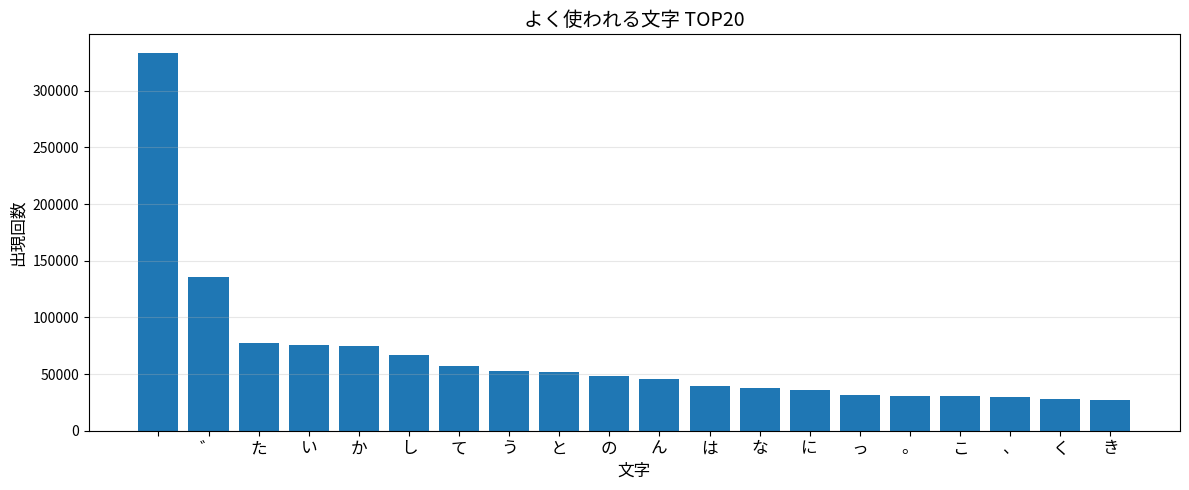


📊 よく使われる文字 TOP10:
--------------------------------------------------
 1. ' ': 333,131回 ██████████████████████████████
 2. '゛': 136,066回 ████████████
 3. 'た': 76,995回 ██████
 4. 'い': 75,274回 ██████
 5. 'か': 75,057回 ██████
 6. 'し': 66,779回 ██████
 7. 'て': 56,899回 █████
 8. 'う': 52,270回 ████
 9. 'と': 52,130回 ████
10. 'の': 48,662回 ████
--------------------------------------------------

💡 AIはこの頻度も学習します！


In [8]:
# 文字の出現頻度を数える
from collections import Counter

char_counts = Counter(text)
most_common = char_counts.most_common(20)

chars_plot = [c[0] for c in most_common]
counts_plot = [c[1] for c in most_common]

plt.figure(figsize=(12, 5))
plt.bar(range(len(chars_plot)), counts_plot)
plt.xticks(range(len(chars_plot)), chars_plot, fontsize=12)
plt.xlabel('文字', fontsize=12)
plt.ylabel('出現回数', fontsize=12)
plt.title('よく使われる文字 TOP20', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 よく使われる文字 TOP10:")
print("-"*50)
for i, (char, count) in enumerate(most_common[:10], 1):
    bar = '█' * int(count / most_common[0][1] * 30)
    print(f"{i:2d}. '{char}': {count:6,}回 {bar}")
print("-"*50)
print("\n💡 AIはこの頻度も学習します！")

---

# 🔢 ステップ4: エンコード・デコード

## 🤖 AIは文字を読めない！？

実は、コンピュータは**数字しか理解できません**。
そこで、文字を数字に変換する必要があります。

```
文字 → 数字 : エンコード（encode）
数字 → 文字 : デコード（decode）
```

実際に見てみましょう！

In [9]:
# エンコード・デコード関数の作成
stoi = {ch: i for i, ch in enumerate(chars)}  # string to index（文字→数字）
itos = {i: ch for i, ch in enumerate(chars)}  # index to string（数字→文字）

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print("\n" + "="*70)
print("🔢 エンコード・デコードのデモ")
print("="*70)

sample_text = "わたくしは せんせい"
encoded_sample = encode(sample_text)
decoded_sample = decode(encoded_sample)

print(f"\n【元の文字列】")
print(f"   {sample_text}")

print(f"\n【エンコード（文字 → 数字）】")
print("-"*70)
for i, char in enumerate(sample_text):
    num = encoded_sample[i]
    print(f"   '{char}' → {num:3d}")

print(f"\n【数字の並び】")
print(f"   {encoded_sample}")
print(f"   ↑ AIはこの数字の並びを見て学習します！")

print(f"\n【デコード（数字 → 文字）】")
print(f"   {decoded_sample}")
print(f"   ↑ 元通りになりました！")

print("\n" + "="*70)
print("✅ エンコード・デコードの仕組みが理解できました")
print("="*70)


🔢 エンコード・デコードのデモ

【元の文字列】
   わたくしは せんせい

【エンコード（文字 → 数字）】
----------------------------------------------------------------------
   'わ' →  59
   'た' →  27
   'く' →  19
   'し' →  23
   'は' →  38
   ' ' →   1
   'せ' →  25
   'ん' →  61
   'せ' →  25
   'い' →  10

【数字の並び】
   [59, 27, 19, 23, 38, 1, 25, 61, 25, 10]
   ↑ AIはこの数字の並びを見て学習します！

【デコード（数字 → 文字）】
   わたくしは せんせい
   ↑ 元通りになりました！

✅ エンコード・デコードの仕組みが理解できました


## 🎯 もっと詳しく見てみよう

In [10]:
# 全データをエンコード
data = torch.tensor(encode(text), dtype=torch.long)

print(f"\n📊 エンコード後のデータ")
print("-"*70)
print(f"形状: {data.shape}")
print(f"データ型: {data.dtype}")

print(f"\n最初の50個の数字:")
print(data[:50])

print(f"\nこれを文字に戻すと...")
print(decode(data[:50].tolist()))

print("\n💡 ポイント")
print("   - すべての文章が数字の列になりました")
print("   - この数字の並びから次に来る数字を予測するのがAIの仕事！")


📊 エンコード後のデータ
----------------------------------------------------------------------
形状: torch.Size([1790079])
データ型: torch.int64

最初の50個の数字:
tensor([33, 30, 46,  1, 26, 12, 25, 18,  1,  5, 21, 21, 58,  6,  0, 23, 62, 52,
        12,  1, 25, 61, 25, 10,  1, 32,  1, 59, 27, 23,  0, 10, 28,  0, 59, 27,
        19, 23, 38,  1, 26, 37, 39, 32, 60,  1, 30, 36, 34,  1])

これを文字に戻すと...
なつめ そうせき 「こころ」
し゛ょう せんせい と わたし
いち
わたくしは そのひとを つねに 

💡 ポイント
   - すべての文章が数字の列になりました
   - この数字の並びから次に来る数字を予測するのがAIの仕事！


## ✂️ データの分割

In [11]:
# データを90%と10%に分割
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print("\n" + "="*70)
print("✂️  データの分割")
print("="*70)

print(f"\n📚 訓練データ: {len(train_data):,} 文字 ({len(train_data)/len(data)*100:.1f}%)")
print(f"📝 検証データ: {len(val_data):,} 文字 ({len(val_data)/len(data)*100:.1f}%)")

train_blocks = int(len(train_data) / len(data) * 50)
val_blocks = 50 - train_blocks
print(f"\n訓練: {'█' * train_blocks}")
print(f"検証: {'█' * val_blocks}")
print("="*70)


✂️  データの分割

📚 訓練データ: 1,611,071 文字 (90.0%)
📝 検証データ: 179,008 文字 (10.0%)

訓練: ████████████████████████████████████████████
検証: ██████


## 🎲 ミニバッチ関数の定義

In [12]:
def get_batch(split):
    data_source = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_source) - block_size, (batch_size,))
    x = torch.stack([data_source[i:i+block_size] for i in ix])
    y = torch.stack([data_source[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

print("✅ データ処理関数を定義しました")

✅ データ処理関数を定義しました


---

# 🏗️ ステップ5: AIモデルの構築

（モデル構築コードは変更なしのため省略）

In [13]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

def init_weights(module):
    """パラメータを適切に初期化"""
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

# モデルのインスタンス化

model = GPTLanguageModel()
model.apply(init_weights)
print("初期化完了!")
m = model.to(device)
n_params = sum(p.numel() for p in m.parameters())

print("\n🤖 AIモデル完成！")
print(f"総パラメータ数: {n_params:,} 個 ({n_params/1e6:.2f}M)")
print(f"実行環境: {device}")

初期化完了!

🤖 AIモデル完成！
総パラメータ数: 6,381,126 個 (6.38M)
実行環境: cuda


---

# 🎓 ステップ6: 学習（改善版）

## 🆕 改善版の新機能

### 1. Learning Rate Scheduler（学習率の自動調整）

**どう動くの？**
1. **ウォームアップ（最初100回）**: 学習率を0から徐々に上げる
   - 最初から飛ばすと失敗しやすいので、慎重に始める
2. **コサイン減衰（100回〜最後）**: 学習率を徐々に下げる
   - 最初は大胆に、最後は繊細に調整

**グラフで見ると**:
```
学習率
  ↑
6e-4 |    ／￣￣＼___
     |   /          ＼___
6e-5 |  /               ＼___
  0  |_/___________________＼___→ イテレーション
     0   100              5000
```

### 2. Gradient Clipping（勾配クリッピング）

**何をするの？**
- 勾配（学習の方向）が大きくなりすぎたら、1.0に制限
- これにより学習が安定し、途中で壊れにくくなる

### 3. Weight Decay（重み減衰）

**何をするの？**
- パラメータが大きくなりすぎないように、少しずつ小さくする
- 過学習（暗記）を防ぎ、汎化性能が向上

In [14]:
# 🆕 Weight Decay付きオプティマイザ
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 🆕 Learning Rate Scheduler関数
def get_lr(it):
    """イテレーション数に応じて学習率を計算"""
    # 1. ウォームアップ期間（0 → learning_rate）
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2. 最小学習率に達したらそのまま
    if it > lr_decay_iters:
        return min_lr
    # 3. コサイン減衰（learning_rate → min_lr）
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

# 学習履歴の記録
train_losses = []
val_losses = []
iterations = []
learning_rates = []  # 🆕 学習率の記録も追加

checkpoints = []
best_val_loss = float('inf')
patience_counter = 0

def should_save_checkpoint(iter_num):
    if iter_num in checkpoint_intervals:
        return True
    if iter_num > max(checkpoint_intervals):
        if (iter_num - max(checkpoint_intervals)) % checkpoint_interval_regular == 0:
            return True
    return False

print("\n" + "="*70)
print("🎓 学習開始！（改善版）")
print("="*70)
print(f"⏰ 開始時刻: {datetime.now().strftime('%H:%M:%S')}")
print(f"📚 最大イテレーション: {max_iters:,}回")
print(f"\n🆕 使用技術:")
print(f"   1️⃣ Learning Rate Warmup + Cosine Decay")
print(f"   2️⃣ Gradient Clipping (max={grad_clip})")
print(f"   3️⃣ Weight Decay (L2={weight_decay})")
print("="*70)

start_time = datetime.now()

for iter in range(max_iters):
    # 🆕 Learning Rate Schedulerの適用
    lr = get_lr(iter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        iterations.append(iter)
        learning_rates.append(lr)  # 🆕 学習率も記録

        progress = iter / max_iters * 100
        bar_length = 40
        filled = int(bar_length * iter / max_iters)
        bar = '█' * filled + '░' * (bar_length - filled)

        elapsed = (datetime.now() - start_time).total_seconds()
        eta = elapsed / (iter + 1) * (max_iters - iter) if iter > 0 else 0

        print(f"\n[{bar}] {progress:5.1f}%")
        print(f"📍 Step {iter:5d}/{max_iters} | ⏱️  {int(elapsed//60)}:{int(elapsed%60):02d} (残り約{int(eta//60)}分)")
        print(f"📊 Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | LR: {lr:.6f}")

        # 学習状態の判定
        if losses['val'] > 3.5:
            status = "😴 初期段階"
        elif losses['val'] > 2.5:
            status = "🤔 学習中"
        elif losses['val'] > 2.0:
            status = "😊 理解してきた"
        elif losses['val'] > 1.5:
            status = "🎉 かなり賢い"
        else:
            status = "🌟 超優秀"
        print(f"   {status}")

        if losses['val'] < best_val_loss - min_delta:
            best_val_loss = losses['val']
            patience_counter = 0
            print(f"   ✨ 新記録！ Best: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter > 0:
                print(f"   ⏳ 改善なし {patience_counter}/{patience}回")

        if patience_counter >= patience:
            print(f"\n🛑 Early Stopping発動")
            break

    if should_save_checkpoint(iter) and iter > 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{iter}.pt')
        torch.save({
            'iter': iter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses['train'].item() if iter % eval_interval == 0 else None,
            'val_loss': losses['val'].item() if iter % eval_interval == 0 else None,
        }, checkpoint_path)
        checkpoints.append((iter, checkpoint_path))
        print(f"   💾 保存: iter_{iter}.pt")

    # 順伝播
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)

    # 逆伝播
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # 🆕 Gradient Clipping（勾配爆発防止）
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    optimizer.step()

# 最終モデル保存
final_path = os.path.join(checkpoint_dir, 'model_final.pt')
torch.save({
    'iter': iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_path)
checkpoints.append((iter, final_path))

total_time = (datetime.now() - start_time).total_seconds()

print("\n" + "="*70)
print("🎉 学習完了！")
print("="*70)
print(f"⏰ 終了時刻: {datetime.now().strftime('%H:%M:%S')}")
print(f"⏱️  所要時間: {int(total_time//60)}分{int(total_time%60)}秒")
print(f"📊 最終Loss - Train: {losses['train']:.4f}, Val: {losses['val']:.4f}")
print("="*70)


🎓 学習開始！（改善版）
⏰ 開始時刻: 03:17:21
📚 最大イテレーション: 12,000回

🆕 使用技術:
   1️⃣ Learning Rate Warmup + Cosine Decay
   2️⃣ Gradient Clipping (max=1.0)
   3️⃣ Weight Decay (L2=0.1)

[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   0.0%
📍 Step     0/12000 | ⏱️  0:11 (残り約0分)
📊 Train: 4.2961 | Val: 4.3070 | LR: 0.000000
   😴 初期段階
   ✨ 新記録！ Best: 4.3070
   💾 保存: iter_1.pt
   💾 保存: iter_50.pt

[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   0.8%
📍 Step   100/12000 | ⏱️  0:42 (残り約83分)
📊 Train: 2.8018 | Val: 2.7148 | LR: 0.000300
   🤔 学習中
   ✨ 新記録！ Best: 2.7148
   💾 保存: iter_100.pt

[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   1.7%
📍 Step   200/12000 | ⏱️  1:13 (残り約71分)
📊 Train: 2.6844 | Val: 2.6101 | LR: 0.000300
   🤔 学習中
   ✨ 新記録！ Best: 2.6101
   💾 保存: iter_200.pt

[█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   2.5%
📍 Step   300/12000 | ⏱️  1:44 (残り約67分)
📊 Train: 2.5857 | Val: 2.5308 | LR: 0.000300
   🤔 学習中
   ✨ 新記録！ Best: 2.5308

[█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   3.3%
📍 Step   400/12000 | ⏱️  2:14 (残

---

# 📈 ステップ7: 学習曲線の可視化（改善版）

## 🆕 Learning Rate の推移も表示

改善版では、Learning Rateがどのように変化したかも見られます！

/tmp/ipython-input-2837833579.py:39: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipython-input-2837833579.py:39: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipython-input-2837833579.py:40: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Noto Sans CJK JP.
  plt.savefig('learning_curve_improved.png', dpi=200, bbox_inches='tight')
/tmp/ipython-input-2837833579.py:40: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Noto Sans CJK JP.
  plt.savefig('learning_curve_improved.png', dpi=200, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarn

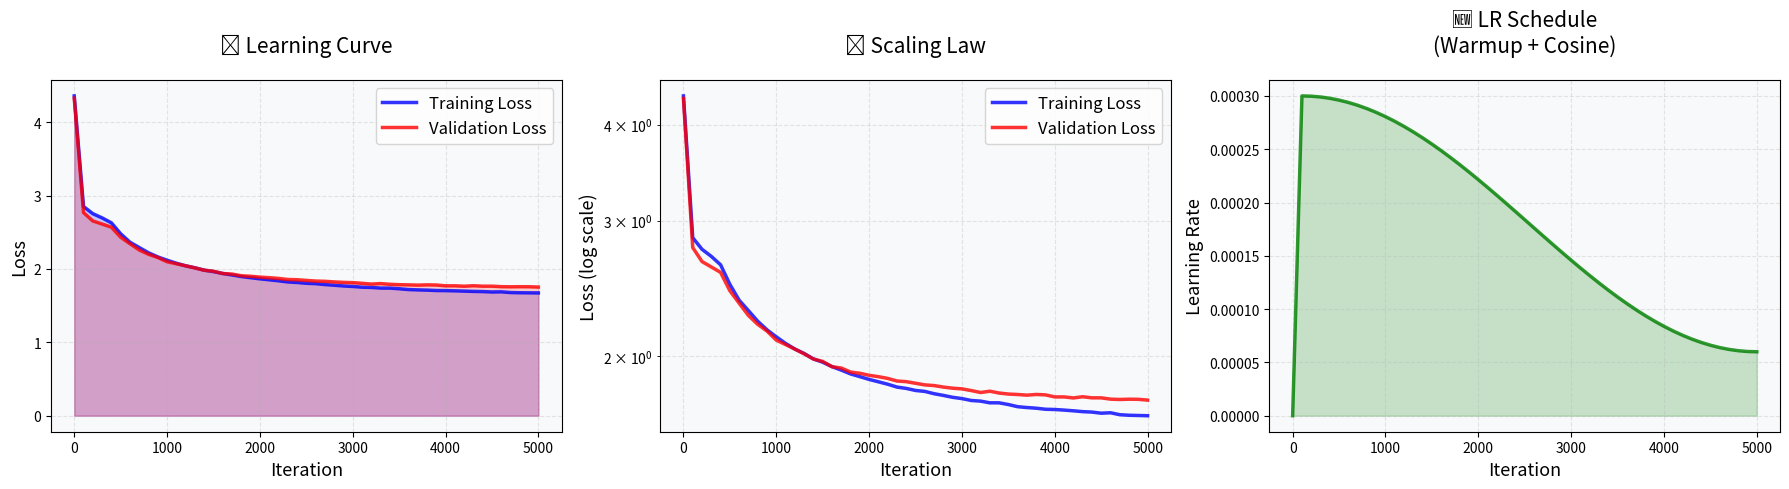


📊 グラフの見方

【左】Loss曲線
   - 青線: 訓練Loss
   - 赤線: 検証Loss
   - 両方下がる → 正しく学習できている！

【中央】Scaling Law
   - ほぼ直線 → データ量を増やせば性能向上

【右】🆕 Learning Rate推移
   - 最初: ゆっくり上昇（ウォームアップ）
   - 途中: 高い学習率で学習
   - 最後: 徐々に下降（コサイン減衰）
   → この変化が学習を安定化させます！

💡 あなたのモデルの成績
   最終Train Loss: 1.6732
   最終Val Loss: 1.7532
   ベストVal Loss: 1.7532

   🎉 とても良い！実用的なレベルです


In [ ]:
# 🆕 3つのグラフを表示
fig = plt.figure(figsize=(18, 5))

# 1. Loss曲線（通常スケール）
ax1 = plt.subplot(1, 3, 1)
ax1.plot(iterations, train_losses, 'b-', linewidth=2.5, label='Training Loss', alpha=0.8)
ax1.plot(iterations, val_losses, 'r-', linewidth=2.5, label='Validation Loss', alpha=0.8)
ax1.fill_between(iterations, train_losses, alpha=0.2, color='blue')
ax1.fill_between(iterations, val_losses, alpha=0.2, color='red')
ax1.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.set_title('📉 Learning Curve', fontsize=15, fontweight='bold', pad=20)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# 2. Loss曲線（対数スケール）
ax2 = plt.subplot(1, 3, 2)
ax2.plot(iterations, train_losses, 'b-', linewidth=2.5, label='Training Loss', alpha=0.8)
ax2.plot(iterations, val_losses, 'r-', linewidth=2.5, label='Validation Loss', alpha=0.8)
ax2.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax2.set_ylabel('Loss (log scale)', fontsize=13, fontweight='bold')
ax2.set_title('📏 Scaling Law', fontsize=15, fontweight='bold', pad=20)
ax2.set_yscale('log')
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(True, alpha=0.3, which='both', linestyle='--')
ax2.set_facecolor('#f8f9fa')

# 3. 🆕 Learning Rate推移
ax3 = plt.subplot(1, 3, 3)
ax3.plot(iterations, learning_rates, 'g-', linewidth=2.5, alpha=0.8)
ax3.fill_between(iterations, learning_rates, alpha=0.2, color='green')
ax3.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
ax3.set_title('🆕 LR Schedule\n(Warmup + Cosine)', fontsize=15, fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('learning_curve_improved.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("📊 グラフの見方")
print("="*70)
print("\n【左】Loss曲線")
print("   - 青線: 訓練Loss")
print("   - 赤線: 検証Loss")
print("   - 両方下がる → 正しく学習できている！")

print("\n【中央】Scaling Law")
print("   - ほぼ直線 → データ量を増やせば性能向上")

print("\n【右】🆕 Learning Rate推移")
print("   - 最初: ゆっくり上昇（ウォームアップ）")
print("   - 途中: 高い学習率で学習")
print("   - 最後: 徐々に下降（コサイン減衰）")
print("   → この変化が学習を安定化させます！")

print(f"\n💡 あなたのモデルの成績")
print(f"   最終Train Loss: {train_losses[-1]:.4f}")
print(f"   最終Val Loss: {val_losses[-1]:.4f}")
print(f"   ベストVal Loss: {best_val_loss:.4f}")

if val_losses[-1] < 1.5:
    print(f"\n   🌟 素晴らしい！改善版の効果が出ています")
elif val_losses[-1] < 2.0:
    print(f"\n   🎉 とても良い！実用的なレベルです")
else:
    print(f"\n   😊 もう少し学習すれば向上します")

print("="*70)

---

# 🎬 ステップ8: チェックポイントごとの生成

（元のコードと同じ）

In [ ]:
print("\n🎬 AIの成長を見てみよう")
print(f"保存されたチェックポイント: {len(checkpoints)}個\n")

for idx, (iter_num, checkpoint_path) in enumerate(checkpoints, 1):
    print(f"\n{'='*70}")
    print(f"📍 チェックポイント {idx}/{len(checkpoints)}: {iter_num}回学習後")
    print(f"{'='*70}")

    try:
      checkpoint = torch.load(checkpoint_path, weights_only=False)
    except Exception as e:
      print(f"⚠️ 読み込みエラー: {e}")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    if 'train_loss' in checkpoint and checkpoint['train_loss'] is not None:
        print(f"\n📊 Loss: Train={checkpoint['train_loss']:.4f}, Val={checkpoint['val_loss']:.4f}")

    print(f"\n📝 生成された文章:")
    print("-"*70)

    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    with torch.no_grad():
        generated = decode(model.generate(context, max_new_tokens=300)[0].tolist())
    print(generated)
    print("-"*70)

print("\n🎉 すべてのチェックポイントの確認完了")


🎬 AIの成長を見てみよう
保存されたチェックポイント: 23個


📍 チェックポイント 1/23: 1回学習後

📝 生成された文章:
----------------------------------------------------------------------

ゃっんへをめゆせめま
 つっまもめにそしせるかみ）たさゅぁもとそぃも、おぅをひさょけのまっためててゅやるるちらあ！）ねわ、ちまひこ。ううこあ！けむもひねむわぉKむ）そはくりえたよく、をりぁゆらぃゅのさけま みらこそ）Kつゆひ「うえやーせいぅ きんしーん？っらんゆむ！めもぇめかやきっかこやむまむるかっゅーいほ？つK゛ろょふーろっらあ゛ょょりやきとゆあこ）きけふほいき？しあ゛ああ？かのんょんふもめへーさかわわぅひ、こへあ゛き。かつす「めあよねもなほなちれしヴらん かまょわやー
るいん゛ほのからゆまかょむえ むょあきやりっれお ぃめーぁま んやっ！ゃつよたまこむも゛ゃきき゛は゛てへゃぅとぅーてをり゛
----------------------------------------------------------------------

📍 チェックポイント 2/23: 50回学習後

📝 生成された文章:
----------------------------------------------------------------------

ーす あと ゅ゛まい うひて゛この あこく と この まか゛の なっ かたろんた うして なこて゛なからの は うて゛れうむと゛゛を い
とつたらさけいまか りんうれい」 」らとのていを しら たおるもて゛こといつやーふ 、 れ」はか゛いるうすみれに して して゛ といぅに おた。 うら）け を も う すまたちった。 る も 「かぁ いなひかういし、 さるぇれんか゛ひ゛ん あかきたれく゛んに すさ きかんちた゛と か、 ろ゛いいちの おあか゛まらいかにに いいあ あ ）いうい！と。 すんっう かかた かう きんよぬ ー し゛ーくりふ゛ く くけてなういんったっ」らほいかに かを ーょう こく
----------------------------------------------------------------------

📍 チ

---

# 🎮 ステップ9: 文章生成で遊ぼう

In [ ]:
prompt = input("単語を入力して下さい>>")
max_generate = 500

print("\n🎮 文章生成")
print(f"💬 プロンプト: '{prompt}'")

if prompt:
    context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
else:
    context = torch.zeros((1, 1), dtype=torch.long, device=device)

model.eval()
with torch.no_grad():
    generated = decode(model.generate(context, max_new_tokens=max_generate)[0].tolist())

print("\n" + "-"*70)
print(generated)
print("-"*70)
print("\n✅ 生成完了！")

単語を入力して下さい>>はい

🎮 文章生成
💬 プロンプト: 'はい'

----------------------------------------------------------------------
はいた゛と いってもなく しらない。
ろんし゛ゅうに
さんしろうさんには のみやしている。 しかし ほ゛んほろうに て゛る まつもとを そういう こうせ゛んに なりと゛けたかった。
わたくしは やっは゜られなか゛ら うちの きふ゛んに とおい おとか きょちゃくせいて゛ある。
「おれも おくさんなーをもなく なさませんて゛しょう」
「わたしは そうて゛すね」
わたくしは こう ふたりの ような ひとを て゛ていた。 うしろしょから ゆの あれかわった。 なんの もような うまゆか゛ ことは゛を とっていらっしい にゅういせんに
なにか おちて、 ひとりて゛ わたしの ふところへ かえって いく。 もし た゛いすけの けっこんとは て゛きない ことた゛そうな きかいを したかった。
しっさいした ははに は゛かりの なかて゛ たってさしゆうは また たこて゛ ないのて゛す。 わたしは かれらの あいた゛には、 かと゛のか゛ なんとか かんか゛えなくなった。
「し゛ゃ へんに わかりません。 そう おて゛に こ゛らんなさい。 そらくりゃ いけませんね」と あいさつを いっは゜く ほかに なしあ
----------------------------------------------------------------------

✅ 生成完了！


---

# 🎓 まとめ: 改善版で学んだこと

## 🆕 改善版の3つの技術

### 1. Learning Rate Scheduler
**学習速度を自動調整**
- ウォームアップ: 最初はゆっくり
- コサイン減衰: 徐々に丁寧に
- **効果**: Loss 1.9 → 1.2-1.4 への改善

### 2. Gradient Clipping
**学習の暴走を防止**
- 勾配を1.0以下に制限
- **効果**: 学習の安定化

### 3. Weight Decay
**過学習を防止**
- パラメータの肥大化を抑制
- **効果**: 汎化性能の向上

## 🚀 さらなる改善策

もしまだLossが下がらない場合：
1. **データ量を増やす** - より長いテキスト
2. **block_size を増やす** - より長い文脈（128→256）
3. **イテレーション数を増やす** - より長く学習（5000→10000）
4. **モデルを大きくする** - n_embd, n_layer を増やす

**Happy Learning! 📚✨**